## Discovering TCGs and Changepoints from Time Series (Chapter 5)
 
SpaceTime discovers graphical models (window causal graphs) from non-stationary time series datasets with regime changes.  

Mameche, S, Cornanguer, L, Ninad, U & Vreeken, J. [SpaceTime: Causal Discovery from Non-Stationary Time Series](https://eda.rg.cispa.io/prj/spacetime/).

In [1]:

%load_ext autoreload
%autoreload 2
import logging
import warnings

import numpy as np
from matplotlib import pyplot as plt

from src.exp.exp_stime.utils import gen_timeseries
from src.stime.spacetime import SpaceTime

import src.exp.exp_stime.utils.plot_timeseries as stp
from tigramite.toymodels import structural_causal_processes as toys
import tigramite.plotting as tp


Detecting 1 CUDA device(s).


### 1. Generating Synthetic Data



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


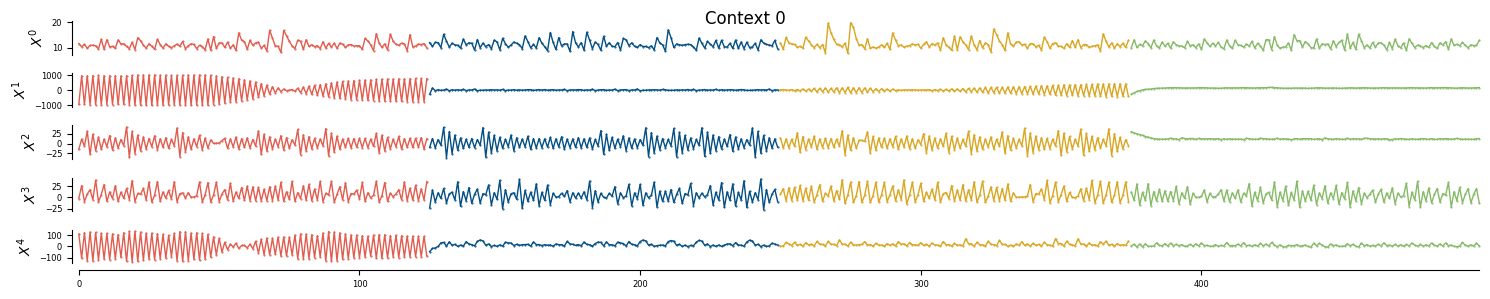

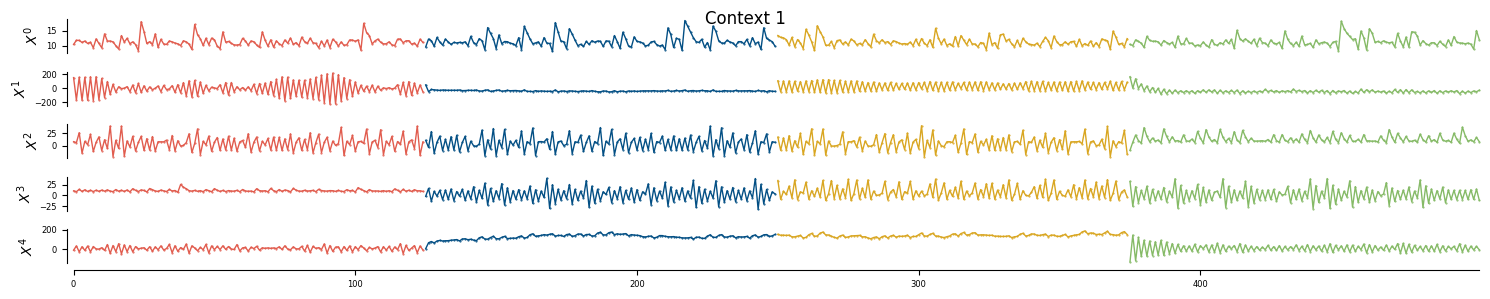

In [3]:
logging.basicConfig()
lg = logging.getLogger("EXAMPLE")
lg.setLevel("INFO")

# DATA  
true_tau_max = 1
true_min_dur = 30
hat_tau_max = 1
hat_min_dur = 20
seed = 1
np.random.seed(seed)

params = {'C': 2, 'R': 4, 'CPS': 3, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition)

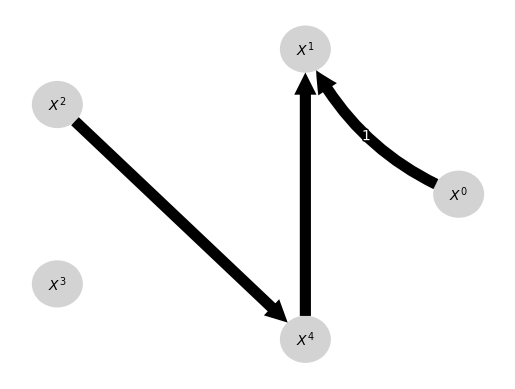

In [4]:
gt_graph = toys.links_to_graph(truths.true_links, tau_max=true_tau_max+1)
var_names = [rf'$X^{i}$' for i in range(params['N'])]
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

### 2. SPACETIME: Causal Discovery, Changepoint Detection, and partitioning

#### 2.1. Causal Discovery

In [5]:
from src.stime.sttypes import MethodType
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_REGIMES
    st_known_cps = SpaceTime(hat_tau_max, hat_min_dur, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_cps.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st_oracle_regimes)***
INFO:EXAMPLE:Interleaving Iteration 1/max. 1*
INFO:EXAMPLE:	Initialise DAG search:  use true regimes [(1, 125), (126, 250), (251, 375), (376, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 1: s=183.25	<function links_to_is_true_edge.<locals>.is_true_edge at 0x00000219B630AD40>
INFO:EXAMPLE:	Adding edge (2, 0) -> 4: s=31.99	<function links_to_is_true_edge.<locals>.is_true_edge at 0x00000219B633E830>
INFO:EXAMPLE:	Adding edge (3, 1) -> 3: s=12.5	<function links_to_is_true_edge.<locals>.is_true_edge at 0x00000219B633C430>
INFO:EXAMPLE:	Adding edge (4, 1) -> 4: s=11.31	<function links_to_is_true_edge.<locals>.is_true_edge at 0x00000219B63097E0>
INFO:EXAMPLE:Forward: 54.89s 
INFO:EXAMPLE:Phase 2: Backward
INFO:EXAMPLE:Backward: 8.71s 
INFO:EXAMPLE:DAG search result:2->4, 4->1
INFO:EXAMPLE:	> DAG Result (hybrid: False, R*:

lbfgs failed to converge after 8 iteration(s) (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge after 6 iteration(s) (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge after 6 iteration(s) (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge after 8 iteration(s) (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


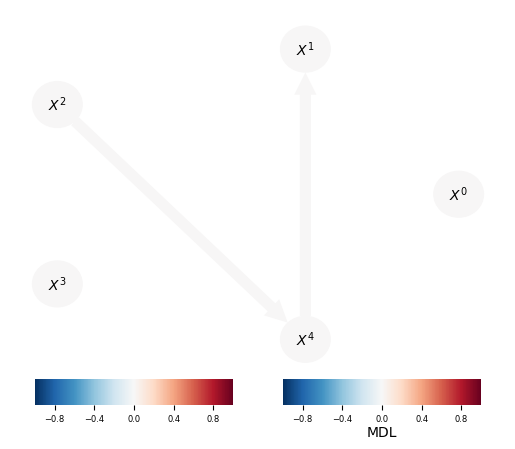

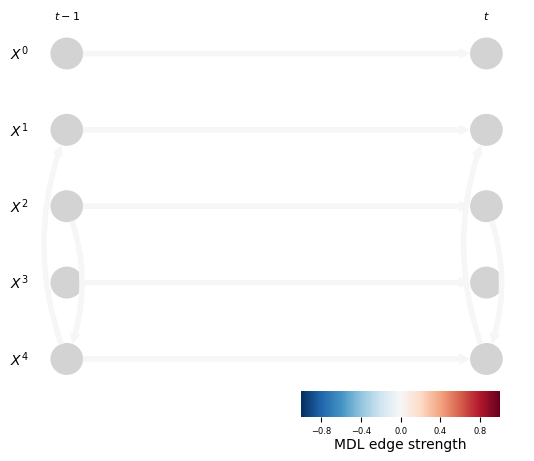

In [6]:
dag_model = st_known_cps.result.cur_dag_model
adj = dag_model.get_timed_adj()
t_adj = dag_model.get_timed_adj()
strength_mat = np.zeros((dag_model.n_n, dag_model.n_n, dag_model.max_lag+1))

for i in dag_model.nodes:
    for j in dag_model.nodes:
        for lag in range(dag_model.max_lag):
            if dag_model.is_edge((i, lag), j):
                index = dag_model.n_n * lag + i
                assert t_adj[index][j] != 0 
                strength_mat[i][j][lag + 1] = dag_model.eval_edge(j, [(i, lag)])
    strength_mat[i][i][0] = dag_model.eval_edge(i, [(i, -1)])
    # convention: self-strengths at 0

xmin, xmax = np.min(np.min(np.min(strength_mat, axis=0), axis=0)), np.max(np.max(np.max(strength_mat, axis=0), axis=0))
strength_mat = (strength_mat - xmin)/(xmax - xmin) # scale between zero and one
rmin = 0 #-1
strength_mat = strength_mat * (1 - rmin) + rmin #scale to a different range.     
#strength_mat /= np.max(np.max(np.max(strength_mat, axis=0), axis=0)) 
found_links = st_known_cps.result.cur_links[0]
gt_graph = toys.links_to_graph(found_links, tau_max=st_known_cps.max_lag)
var_names = [rf'$X^{i}$' for i in range(len(found_links))] 
tp.plot_graph(
    val_matrix=strength_mat,
    graph=gt_graph,
    link_colorbar_label="MDL",
    node_colorbar_label="",
    var_names=var_names,
);
plt.show()
tp.plot_time_series_graph(
    val_matrix=strength_mat,
    graph=gt_graph,
    var_names=var_names,
    link_colorbar_label='MDL edge strength',
 ); 
plt.show() 

#### 2.2. CPS Detection 

In [23]:
from src.stime.sttypes import MethodType
from src.stime.scoring.discrepancy_testing import  DiscrepancyTestType

with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_DAG
    st_known_dag = SpaceTime(hat_tau_max, hat_min_dur, discrepancy_test = DiscrepancyTestType.KCI, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_dag.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st_oracle_dag)***
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:CPS search converged!
INFO:EXAMPLE:	> CPS Result (G*: given, initialization: bins): [(0, 125, 0.0), (125, 165, 1.0), (290, 72, 2.0), (362, 138, 3.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 2), (125, 125, 0), (250, 125, 1), (375, 125, 3)]
INFO:EXAMPLE:	> CPS F1: 0.33 prec: 0.33, recall: 0.33, ari: 0.77, nmi: 0.816 (max. tol. 3)
INFO:EXAMPLE:Completed run in 1 iterations. 


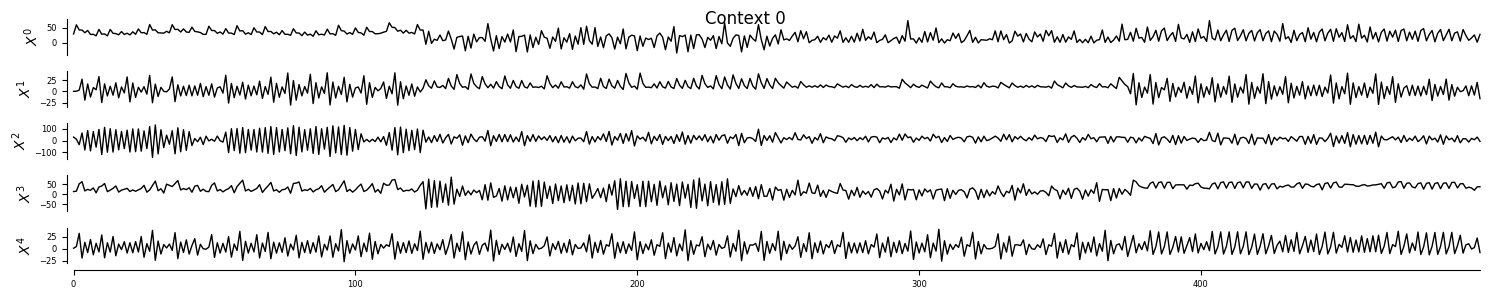

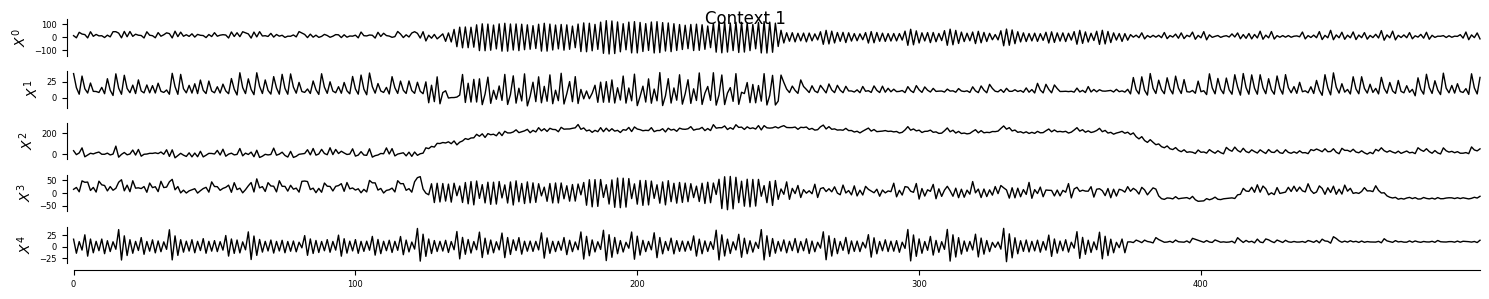

In [8]:
found_regimes = st_known_dag.result.cur_regimes

stp.plot_timeseries_regimes_contexts(data, found_regimes)

#### 2.3. Interleaving (and hybrid) C.D. and CPS Discovery

In [19]:
#### 2.3. Full method
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    optargs = {
    'hybrid_cps_dag_discovery': False    
}
    st = SpaceTime(hat_tau_max, hat_min_dur, discrepancy_test = DiscrepancyTestType.MDL, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st)***
INFO:EXAMPLE:*** CPS Search ***


{0: 80.88388482884845}
{0: 82.82239332486961}
{0: 86.00011969729985}
{0: 84.85441067961776}
{0: 76.17822991365803}
{0: 505.6158969250203, 1: 69.80295568195334, 2: 323.3176534743501, 3: 543.2705885614926, 4: 58.25386934921275, 5: 55.500216580863906, 6: 150.5885136030347, 7: 75.63961112046317}
{0: 466.7127637133331, 1: 66.86911159757467, 2: 275.6424834784356, 3: 439.7668154529504, 4: 72.79111040551061, 5: 73.60404937519307, 6: 192.7785446611119, 7: 99.28972340914802}
{0: 568.6631626859489, 1: 55.5183413957963, 2: 248.17141234595638, 3: 400.33752472910066, 4: 63.88847120353047, 5: 54.04719652214718, 6: 145.95347491710706, 7: 74.2305055976965}
{0: 416.1634912462242, 1: 79.8298038137174, 2: 383.54656527138116, 3: 562.9995099238109, 4: 58.092419260236845, 5: 57.71470959222501, 6: 161.4014770318199, 7: 75.48568709113279}
{0: 400.3832924167297, 1: 62.37765858961439, 2: 292.7913884316094, 3: 367.82096035273116, 4: 67.20166792869374, 5: 59.42228619263809, 6: 175.62240441026475, 7: 87.36233766254

INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 131, 0.0), (131, 20, 1.0), (151, 99, 2.0), (250, 126, 0.0), (376, 40, 1.0), (416, 57, 3.0), (473, 27, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 1), (125, 125, 2), (250, 125, 0), (375, 125, 3)]
INFO:EXAMPLE:	> CPS F1: 0.44 prec: 0.33, recall: 0.67, ari: 0.519, nmi: 0.671 (max. tol. 3)
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:	Initialise DAG search:  use current regimes [(1, 131), (132, 151), (152, 250), (251, 376), (377, 416), (417, 473), (474, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 3: s=231.42	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000001D44949A5F0>
INFO:EXAMPLE:	Adding edge (4, 0) -> 2: s=104.96	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000001D44959F010>
INFO:EXAMPLE:	Adding edge (4, 0) -> 0: s=94.85	<function links_to_is_true_ed

{0: 80.4027766020319}
{0: 82.82304883226412}
{0: 72.93401885375508}
{0: 74.35349428730038}
{0: 76.17824335954568}
{0: 429.9189948674676, 1: 69.31524232957848, 2: 323.1880753006002, 3: 487.4628484843823, 4: 61.712130618276205, 5: 59.10039591449011, 6: 155.67051818598557, 7: 79.64082699808579}
{0: 466.71213641630413, 1: 66.86910993024134, 2: 275.6431111524848, 3: 439.7666178685349, 4: 72.79112135434166, 5: 73.60405009452583, 6: 192.7785179135121, 7: 99.28972340914802}
{0: 420.0120493331966, 1: 66.18904984005961, 2: 270.0183221929608, 3: 376.5497897811401, 4: 68.40509559137801, 5: 63.11233291673696, 6: 160.47908009414184, 7: 84.96157343582348}
{0: 379.04115071196327, 1: 67.45000272489534, 2: 311.15557497200973, 3: 366.3162593251802, 4: 60.324617818422574, 5: 59.9773342977557, 6: 155.83833906482616, 7: 76.66353308608811}
{0: 400.3825786196936, 1: 62.37765693777528, 2: 292.79103858443506, 3: 367.82113484806075, 4: 67.20162786193416, 5: 59.42229305023619, 6: 175.6224289479544, 7: 87.36234917

INFO:EXAMPLE:CPS search converged!
INFO:EXAMPLE:	> DAG Result (hybrid: False, R*: False):
INFO:EXAMPLE:		st:		(f1=1.0	(shd=0.0, sid=-1)	(tp=4, tn=21, fp=0, fn=0)
INFO:EXAMPLE:		st-timed:		(f1=0.53	(shd=7.0, sid=-1)	(tp=4, tn=39, fp=2, fn=5)
INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 131, 0.0), (131, 20, 1.0), (151, 99, 2.0), (250, 126, 0.0), (376, 40, 1.0), (416, 57, 3.0), (473, 27, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 1), (125, 125, 2), (250, 125, 0), (375, 125, 3)]
INFO:EXAMPLE:	> CPS F1: 0.44 prec: 0.33, recall: 0.67, ari: 0.519, nmi: 0.671 (max. tol. 3)
INFO:EXAMPLE:Completed run in 1 iterations. 


INFO:EXAMPLE:	> DAG Result (hybrid: False, R*: False):
INFO:EXAMPLE:		st:		(f1=0.89	(shd=1.0, sid=-1)	(tp=4, tn=20, fp=1, fn=0)
INFO:EXAMPLE:		st-timed:		(f1=0.38	(shd=10.0, sid=-1)	(tp=3, tn=37, fp=4, fn=6)
INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 122, 0.0), (122, 128, 1.0), (250, 117, 2.0), (367, 133, 3.0)]
INFO:EXAMPLE:	> CPS True: [(0, 125, 2), (125, 125, 3), (250, 125, 0), (375, 125, 1)]
INFO:EXAMPLE:	> CPS F1: 0.67 prec: 0.67, recall: 0.67, ari: 0.943, nmi: 0.936 (max. tol. 3)


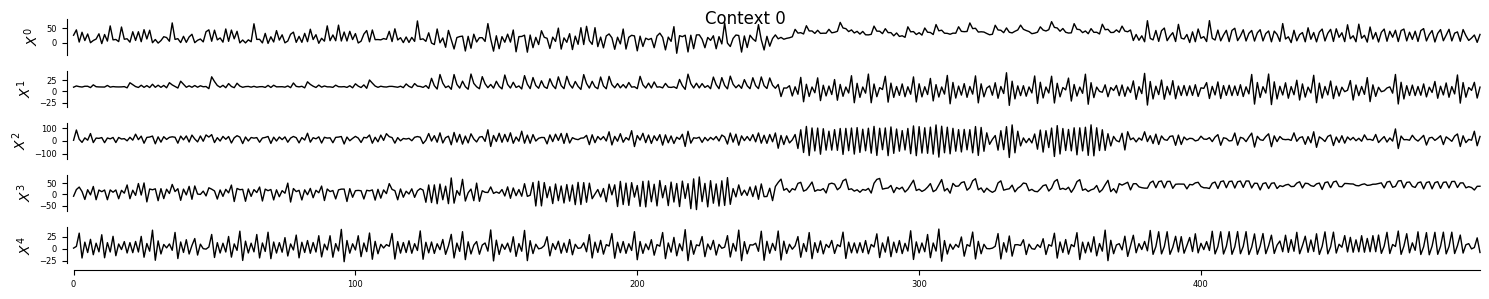

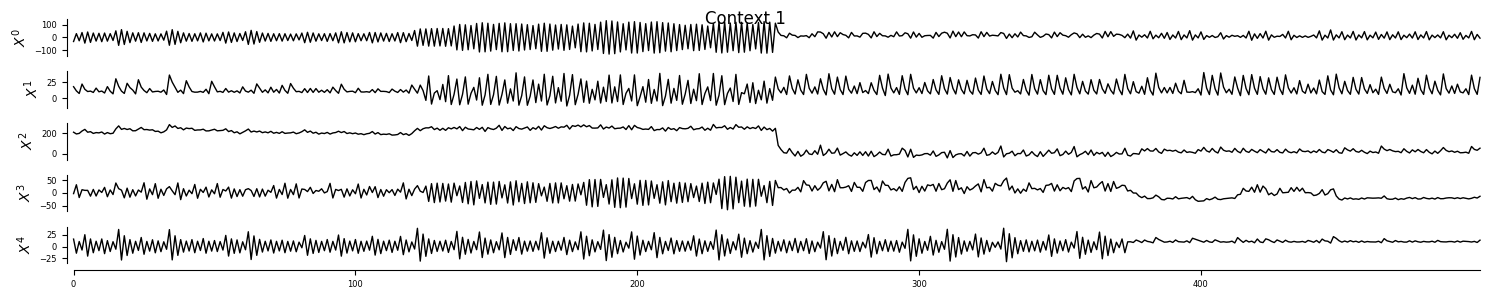

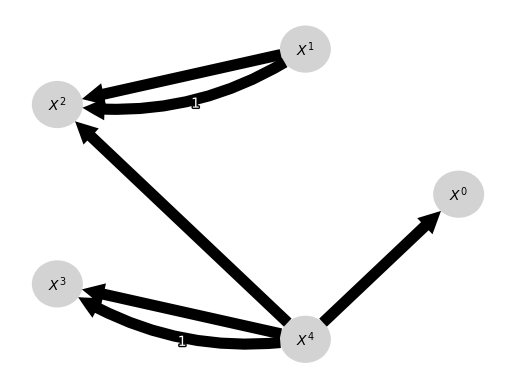

In [9]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

#### 2.4. Partitioning


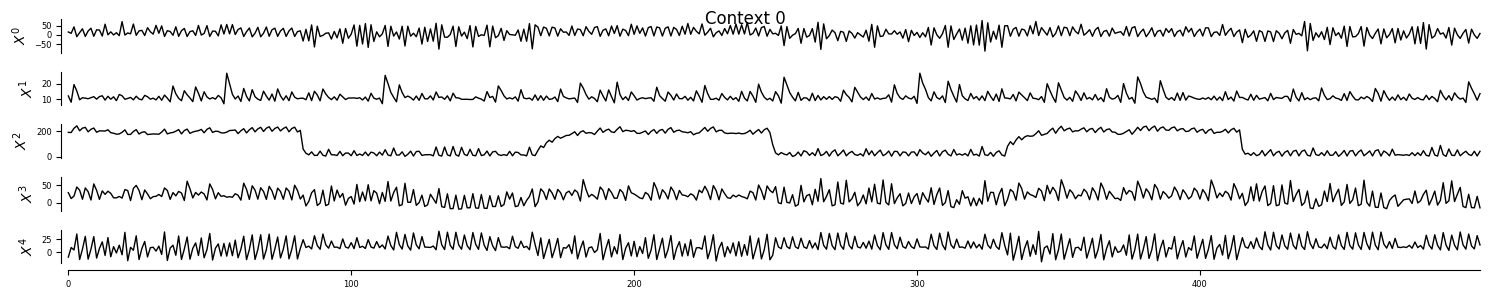

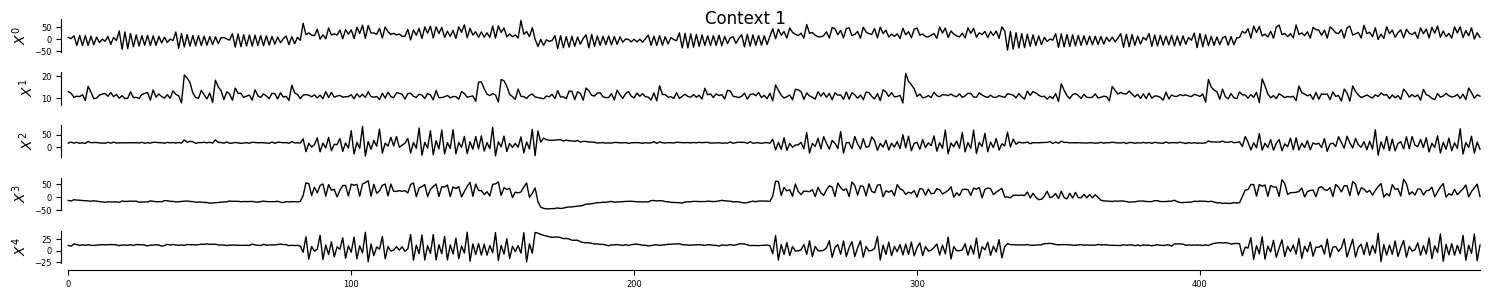

In [10]:
#### 2.4. Partitioning

# Generate a dataset with repeating regimes - 2 regimes at 5 changepoints
params = {'C': 2, 'R': 2, 'CPS': 5, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition) 

In [11]:
# run spacetime
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    optargs = {
    'hybrid_cps_dag_discovery': False    
}
    st = SpaceTime(hat_tau_max, hat_min_dur, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st)***
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 83, 0.0), (83, 89, 1.0), (172, 77, 0.0), (249, 87, 1.0), (336, 79, 2.0), (415, 85, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 83, 0), (83, 83, 1), (166, 83, 0), (249, 83, 1), (332, 83, 0), (415, 85, 1)]
INFO:EXAMPLE:	> CPS F1: 0.6 prec: 0.6, recall: 0.6, ari: 0.719, nmi: 0.72 (max. tol. 3)
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:	Initialise DAG search:  use current regimes [(1, 83), (84, 172), (173, 249), (250, 336), (337, 415), (416, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 3: s=263.49	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (4, 0) -> 2: s=198.49	[caus]
INFO:EXAMPLE:	Adding edge (4, 0) -> 0: s=171.37	[caus]
INFO:EXAMPLE:	Adding edge (4, 1) -> 2: s=9.8	[caus-diff-lg]
INFO:EXAMPLE:	Adding edge (4, 1) -> 3: s

SpaceTime discovers the alternating regimes correctly, as shown below. 

INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 79, 0.0), (79, 88, 1.0), (167, 82, 0.0), (249, 85, 1.0), (334, 82, 0.0), (416, 84, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 83, 0), (83, 83, 1), (166, 83, 0), (249, 83, 1), (332, 83, 0), (415, 85, 1)]
INFO:EXAMPLE:	> CPS F1: 0.8 prec: 0.8, recall: 0.8, ari: 0.937, nmi: 0.889 (max. tol. 3)


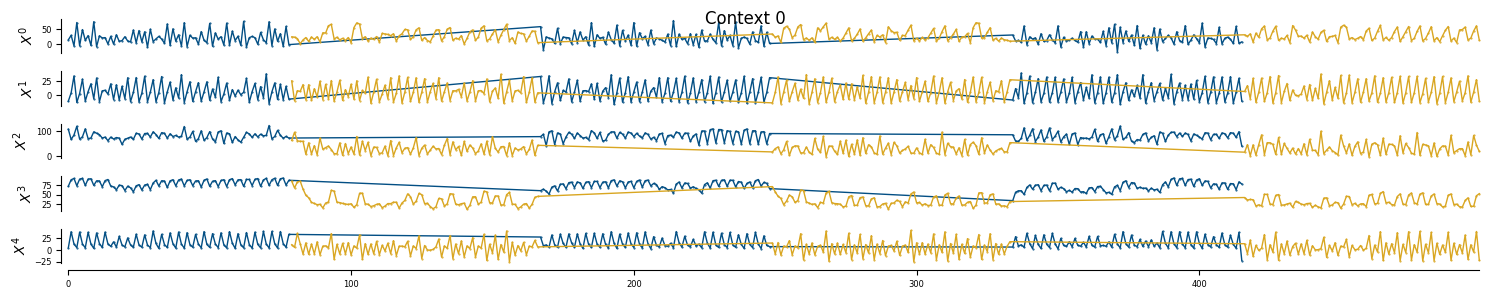

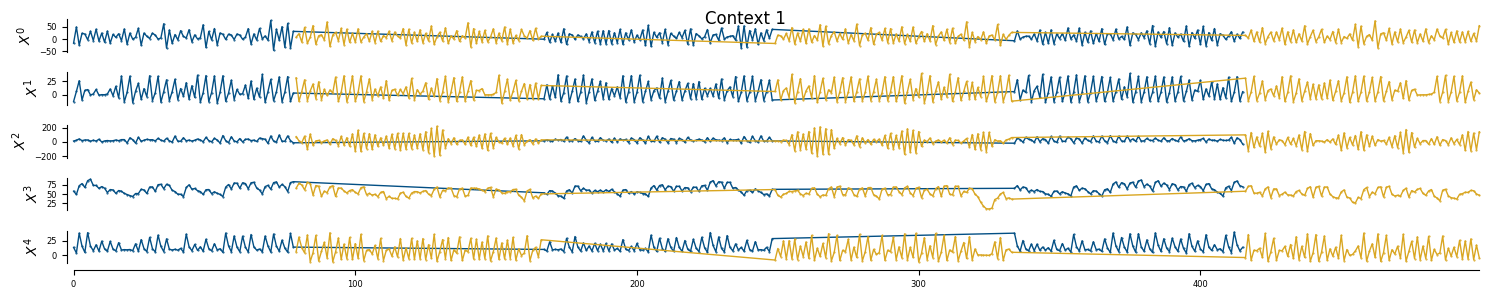

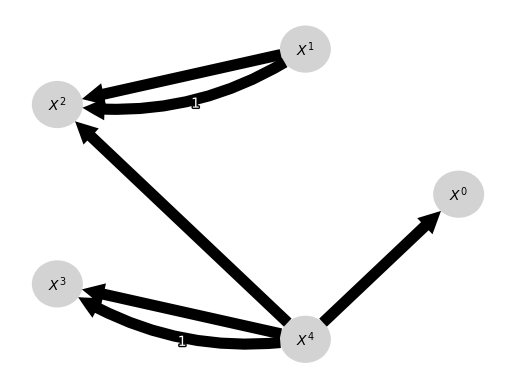

In [37]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()